In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)


from preprocess.graph import graph_topology_5
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from models.graph_water_transformer_cov_no_attention import graph_water_transformer_cov_gate_predictor_no_attention

from losses.loss import gate_loss, water_level_threshold
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1


import random

random.seed(10)
print(random.random())

2023-08-12 12:35:18.331722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 12:35:19.872327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0.5714025946899135


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [4]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


### Graph topology

In [5]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

#### Gate & pump predictor

In [6]:
# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
gate_min = 0.0
gate_max = 1.0

learning_rate = 3e-3
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 700
BATCH = 512

In [7]:
input_shape = train_cov.shape[1:]

In [11]:
gate_predictor, GCNConv = graph_water_transformer_cov_gate_predictor_no_attention(input_shape=input_shape,
                                                                       gcn1=gcn_unit1,
                                                                       gcn2=gcn_unit2,
                                                                       lstm_unit=lstm_units, 
                                                                       num_transformer_blocks=num_transformer_blocks,
                                                                       head_size=head_size,
                                                                       num_heads=num_heads,
                                                                       ff_dim=ff_dim, 
                                                                       atte_reg=atte_reg, 
                                                                       l1_reg=l1_reg, 
                                                                       l2_reg=l2_reg, 
                                                                       dropout=dropout,
                                                                       masked_value=masked_value,
                                                                       gate_min=gate_min,
                                                                       gate_max=gate_max
                                                                      )
gate_predictor._name = "gate_predictor"
# gate_predictor.summary()

In [12]:
gate_predictor.compile(optimizer='adam', loss='mse')

#### water stage predictor

In [13]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

for layer in ws_predictor.layers:
    layer.trainable = False

ws_predictor._name = 'ws_predictor'    
# ws_predictor.summary()

#### Combine gate_predictor and trained ws_predictor

In [14]:
inputs_cov = Input(shape=(96, 12), name='input_cov')
inputs_tws = Input(shape=(5, 72), name='input_tws')
inputs_adj = Input(shape=(5, 5), name='input_adj')

# ================ gate_predictor ================
gate_predictor_output = gate_predictor([inputs_cov, inputs_tws, inputs_adj])  # 24*7


# ============  future inputs with replaced gate & pump prediction ============
replaced_future_gate_pump = layers.Concatenate(axis=-1)([inputs_cov[:, n_hours:, :2], 
                                                         gate_predictor_output, 
                                                         inputs_cov[:, n_hours:, 9:]
                                                        ]
                                                       )

# ============ original past inputs + future inputs with replaced gate & pump prediction ============
merged_inputs_cov = layers.Concatenate(axis=1)([inputs_cov[:, :n_hours, :], replaced_future_gate_pump])

ws_predictor_output = ws_predictor([merged_inputs_cov, inputs_tws, inputs_adj])

filda = Model(inputs=[inputs_cov, inputs_tws, inputs_adj], outputs=[gate_predictor_output, ws_predictor_output], name='filda')
# filda.summary()

Epoch 1/700


2023-08-12 12:36:06.720853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-12 12:36:08.149786: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8a21ee07c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-12 12:36:08.149841: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-12 12:36:08.159508: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-12 12:36:08.572168: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_ws_predictor_loss improved from inf to 2.28132, saving model to ../saved_models/gtnp_gtnp_13_no_attention.h5
151/151 - 33s - loss: 0.4829 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2288 - val_loss: 4.5662 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.2813 - 33s/epoch - 216ms/step
Epoch 2/700


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_ws_predictor_loss improved from 2.28132 to 2.03864, saving model to ../saved_models/gtnp_gtnp_13_no_attention.h5
151/151 - 13s - loss: 0.4414 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2191 - val_loss: 4.0801 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0386 - 13s/epoch - 89ms/step
Epoch 3/700

Epoch 3: val_ws_predictor_loss improved from 2.03864 to 1.86218, saving model to ../saved_models/gtnp_gtnp_13_no_attention.h5
151/151 - 13s - loss: 0.4196 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2084 - val_loss: 3.7268 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.8622 - 13s/epoch - 89ms/step
Epoch 4/700

Epoch 4: val_ws_predictor_loss improved from 1.86218 to 1.73252, saving model to ../saved_models/gtnp_gtnp_13_no_attention.h5
151/151 - 13s - loss: 0.4087 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2032 - val_loss: 3.4671 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7325 - 13s/e

151/151 - 13s - loss: 0.3845 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1921 - val_loss: 2.9426 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4712 - 13s/epoch - 88ms/step
Epoch 28/700

Epoch 28: val_ws_predictor_loss did not improve from 1.47115
151/151 - 13s - loss: 0.3843 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1920 - val_loss: 2.9497 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4747 - 13s/epoch - 87ms/step
Epoch 29/700

Epoch 29: val_ws_predictor_loss improved from 1.47115 to 1.47043, saving model to ../saved_models/gtnp_gtnp_13_no_attention.h5
151/151 - 13s - loss: 0.3842 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1920 - val_loss: 2.9411 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4704 - 13s/epoch - 88ms/step
Epoch 30/700

Epoch 30: val_ws_predictor_loss did not improve from 1.47043
151/151 - 13s - loss: 0.3842 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1920 - val_

Epoch 56/700

Epoch 56: val_ws_predictor_loss did not improve from 1.46618
151/151 - 13s - loss: 0.3804 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1901 - val_loss: 2.9356 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4677 - 13s/epoch - 87ms/step
Epoch 57/700

Epoch 57: val_ws_predictor_loss did not improve from 1.46618
151/151 - 13s - loss: 0.3803 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1901 - val_loss: 2.9345 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4672 - 13s/epoch - 87ms/step
Epoch 58/700

Epoch 58: val_ws_predictor_loss did not improve from 1.46618
151/151 - 13s - loss: 0.3802 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1900 - val_loss: 2.9364 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4681 - 13s/epoch - 87ms/step
Epoch 59/700

Epoch 59: val_ws_predictor_loss improved from 1.46618 to 1.46551, saving model to ../saved_models/gtnp_gtnp_13_no_attention.h5
151/151 - 13s - loss: 

Epoch 84/700

Epoch 84: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3799 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1899 - val_loss: 2.9265 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4632 - 13s/epoch - 86ms/step
Epoch 85/700

Epoch 85: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3799 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1899 - val_loss: 2.9249 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4624 - 13s/epoch - 86ms/step
Epoch 86/700

Epoch 86: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3799 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1899 - val_loss: 2.9286 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4643 - 13s/epoch - 86ms/step
Epoch 87/700

Epoch 87: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3842 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.19

151/151 - 13s - loss: 0.3798 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9267 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4633 - 13s/epoch - 86ms/step
Epoch 114/700

Epoch 114: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3798 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9296 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4648 - 13s/epoch - 86ms/step
Epoch 115/700

Epoch 115: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3798 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9303 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4651 - 13s/epoch - 86ms/step
Epoch 116/700

Epoch 116: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3844 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1917 - val_loss: 3.0535 - val_gate_predictor_loss: 0.0000e+00 - val_ws_

Epoch 143/700

Epoch 143: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3796 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9292 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4646 - 13s/epoch - 87ms/step
Epoch 144/700

Epoch 144: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3796 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1898 - val_loss: 2.9337 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4668 - 13s/epoch - 86ms/step
Epoch 145/700

Epoch 145: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3837 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1913 - val_loss: 3.0576 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5283 - 13s/epoch - 86ms/step
Epoch 146/700

Epoch 146: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3805 - gate_predictor_loss: 0.0000e+00 - ws_predictor_lo

151/151 - 13s - loss: 0.3795 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9459 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4729 - 13s/epoch - 87ms/step
Epoch 173/700

Epoch 173: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3795 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9394 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4697 - 13s/epoch - 86ms/step
Epoch 174/700

Epoch 174: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3796 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9566 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.4783 - 13s/epoch - 86ms/step
Epoch 175/700

Epoch 175: val_ws_predictor_loss did not improve from 1.45857
151/151 - 13s - loss: 0.3795 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1897 - val_loss: 2.9449 - val_gate_predictor_loss: 0.0000e+00 - val_ws_

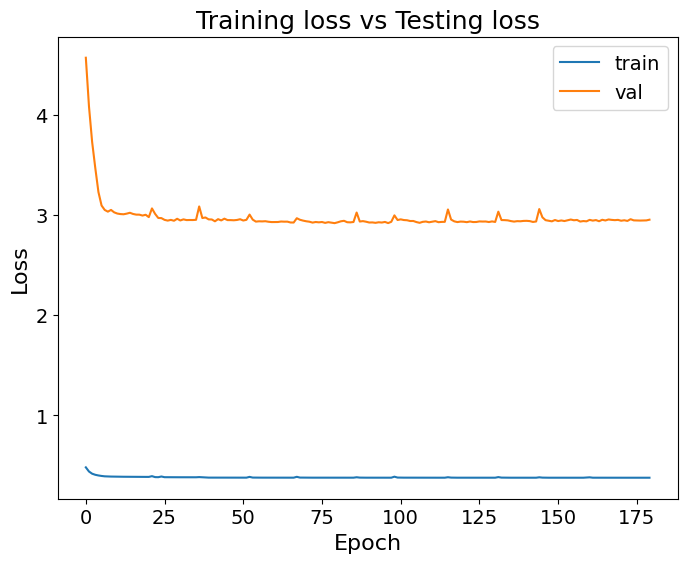

In [15]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

filda.compile(optimizer=Adam(learning_rate=lr_schedule),
             loss=[gate_loss, water_level_threshold], 
             loss_weights=[0.0, 2.0]
            )


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
mc = ModelCheckpoint('../saved_models/gtnp_gtnp_13_no_attention.h5'.format(n_hours, K),
                     monitor='val_ws_predictor_loss',
                     mode='min',
                     verbose=2, 
                     custom_objects={'gate_loss':gate_loss, 'water_level_threshold':water_level_threshold}, 
                     save_best_only=True)


history = filda.fit([train_cov, train_tws_reshape, train_adj_mat], [train_gate_pump_y, train_ws_y],
                   validation_data=([val_cov, val_tws_reshape, val_adj_mat], [val_gate_pump_y, val_ws_y]),
                   batch_size=BATCH, 
                   epochs=EPOCHS, 
                   verbose=2, 
                   callbacks=[es, mc],
                   shuffle=True,
                  )


plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [16]:
saved_model = load_model('../saved_models/gtnp_gtnp_13_no_attention.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

In [17]:
gate_pump_pred, ws_pred = saved_model.predict([test_cov, test_tws_reshape, test_adj_mat])

print(gate_pump_pred.shape)
print(ws_pred.shape)

603/603 [==============================] - 5s 6ms/step
(19268, 24, 7)
(19268, 96)


#### ws pred, gate pred

In [18]:
ws_pred_gate_pred_inv = ws_scaler.inverse_transform(ws_pred)
ws_pred_gate_pred_inv = ws_pred_gate_pred_inv.reshape((-1, K, 4))
ws_pred_gate_pred_inv.shape

(19268, 24, 4)

#### ws true, gate true

In [19]:
ws_true_gate_true = test_ws_y
ws_true_gate_true_inv = ws_scaler.inverse_transform(ws_true_gate_true)
ws_true_gate_true_inv = ws_true_gate_true_inv.reshape((-1, K, 4))
ws_true_gate_true_inv.shape

(19268, 24, 4)

#### ws pred, gate true

In [20]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

ws_pred_gate_true = ws_predictor.predict([test_cov, test_tws_reshape, test_adj_mat])
ws_pred_gate_true_inv = ws_scaler.inverse_transform(ws_pred_gate_true)
ws_pred_gate_true_inv = ws_pred_gate_true_inv.reshape((-1, 24, 4))
ws_pred_gate_true_inv.shape

603/603 [==============================] - 2s 3ms/step


(19268, 24, 4)

### Upper threshould

In [21]:
upper_threshold = 3.5
t1 = 1

flood_threshold_t1(ws_true_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv, t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 96, 96, 118, 117
S1, S25A, S25B, S26 areas: 14.82, 15.22, 18, 20.13
TOTAL time steps: 427; TOTAL areas: 68.61
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 85, 85, 96, 108
S1, S25A, S25B, S26 areas: 11.5466, 12.1773, 13, 17.2181
TOTAL time steps: 374; TOTAL areas: 54.3063
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 32, 27, 40, 61
S1, S25A, S25B, S26 areas: 3.5937, 3.1912, 4, 8.513
TOTAL time steps: 160; TOTAL areas: 19.5877
--------------------------------------------------


In [22]:
flood_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 6, 5, 6, 6
S1, S25A, S25B, S26 areas: 0.84, 0.72, 1, 1.0
TOTAL time steps: 23; TOTAL areas: 3.62
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 5
S1, S25A, S25B, S26 areas: 0.6148, 0.6425, 1, 0.8663
TOTAL time steps: 22; TOTAL areas: 3.0018
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 2, 1, 3, 3
S1, S25A, S25B, S26 areas: 0.1148, 0.0691, 0, 0.3399
TOTAL time steps: 9; TOTAL areas: 0.7518
--------------------------------------------------


In [23]:
flood_threshold(ws_true_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_pred_inv, upper_threshold)

time steps: 10248, areas: 1646.6399002075195
time steps: 12130, areas: 2088.0380942821503
time steps: 8140, areas: 1308.1216714382172


### Lower threshold

In [24]:
lower_threshold = 0
t1 = 1

drought_threshold_t1(ws_true_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv, t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 1346, 1341, 1229, 1250
S1, S25A, S25B, S26 areas: -385.8, -383.38, -345.08, -350.84:
TOTAL time steps: 5166; TOTAL areas: -1465.1
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1390, 1427, 1282, 1476
S1, S25A, S25B, S26 areas: -398.849, -392.0414, -350.2885, -429.5386:
TOTAL time steps: 5575; TOTAL areas: -1570.7176
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 341, 149, 40, 144
S1, S25A, S25B, S26 areas: -60.4825, -23.0314, -4.2482, -21.1427:
TOTAL time steps: 674; TOTAL areas: -108.9048
--------------------------------------------------


In [25]:
drought_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 0, 0, 0, 0
S1, S25A, S25B, S26 areas: 0, 0, 0, 0:
TOTAL time steps: 0; TOTAL areas: 0
--------------------------------------------------


In [26]:
drought_threshold(ws_true_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv, lower_threshold)

time steps: 124148, areas: 35182.6098122485
time steps: 127126, areas: 34960.07284716559
time steps: 13308, areas: 2259.202274329076


In [27]:
ws_true_gate_true_inv_24 = ws_true_gate_true_inv[:, t1, :]
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv[:, t1, :]
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv[:, t1, :]

ws_true_gate_true_inv_24 = ws_true_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv_24.reshape((-1, 1, 4))

drought_threshold(ws_true_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv_24, lower_threshold)

time steps: 5166, areas: 1465.099992136471
time steps: 5575, areas: 1570.7175889443388
time steps: 674, areas: 108.90482664119918
